## Data Ingestion Pipeline

In [1]:
# Read the pdf files
from langchain.document_loaders import DirectoryLoader
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
import os

# Load all the pdf files in the directory
pdf_dir_path = "../data/pdf_files"
pdf_loader = DirectoryLoader(
    pdf_dir_path,
    glob="**/*.pdf", # Patter to match the files
    loader_cls=PyMuPDFLoader,
    show_progress=False
)

pdf_documents = pdf_loader.load()
print(f"Number of pdf documents loaded: {len(pdf_documents)}")
print(pdf_documents)

/Users/neehanth/Documents/Masters/Adv Database Systems/Project/rag-qa-system/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of pdf documents loaded: 49
[Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2013-09-10T00:03:46+00:00', 'source': '../data/pdf_files/embeddings.pdf', 'file_path': '../data/pdf_files/embeddings.pdf', 'total_pages': 12, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2013-09-10T00:03:46+00:00', 'trapped': '', 'modDate': 'D:20130910000346Z', 'creationDate': 'D:20130910000346Z', 'page': 0}, page_content='Efﬁcient Estimation of Word Representations in\nVector Space\nTomas Mikolov\nGoogle Inc., Mountain View, CA\ntmikolov@google.com\nKai Chen\nGoogle Inc., Mountain View, CA\nkaichen@google.com\nGreg Corrado\nGoogle Inc., Mountain View, CA\ngcorrado@google.com\nJeffrey Dean\nGoogle Inc., Mountain View, CA\njeff@google.com\nAbstract\nWe propose two novel model architectures for computing continuous vector repre-\nsentations of words from very large data sets. The quality of these repr

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_documents_recursive(documents, chunk_size=500, chunk_overlap=50):
    """
    Splits each document in the list into smaller chunks using RecursiveCharacterTextSplitter.

    Args:
        documents (List[Document]): List of Document objects to split.
        chunk_size (int): Maximum number of characters per chunk.
        chunk_overlap (int): Number of overlapping characters between chunks.

    Returns:
        List[Document]: List of chunked Document objects.
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    chunked_docs = splitter.split_documents(documents)
    print(f"{len(documents)} documents split into {len(chunked_docs)} chunks.")

    if chunked_docs:
        print("Sample chunk:")
        print(f"Content: {chunked_docs[0].page_content}")
        print(f"Metadata: {chunked_docs[0].metadata}")

    return chunked_docs

chunked_docs = split_documents_recursive(pdf_documents)
chunked_docs

49 documents split into 428 chunks.
Sample chunk:
Content: Efﬁcient Estimation of Word Representations in
Vector Space
Tomas Mikolov
Google Inc., Mountain View, CA
tmikolov@google.com
Kai Chen
Google Inc., Mountain View, CA
kaichen@google.com
Greg Corrado
Google Inc., Mountain View, CA
gcorrado@google.com
Jeffrey Dean
Google Inc., Mountain View, CA
jeff@google.com
Abstract
We propose two novel model architectures for computing continuous vector repre-
sentations of words from very large data sets. The quality of these representations
Metadata: {'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2013-09-10T00:03:46+00:00', 'source': '../data/pdf_files/embeddings.pdf', 'file_path': '../data/pdf_files/embeddings.pdf', 'total_pages': 12, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2013-09-10T00:03:46+00:00', 'trapped': '', 'modDate': 'D:20130910000346Z', 'creationDate': 'D:20130910000346Z', 'page': 0}


[Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2013-09-10T00:03:46+00:00', 'source': '../data/pdf_files/embeddings.pdf', 'file_path': '../data/pdf_files/embeddings.pdf', 'total_pages': 12, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2013-09-10T00:03:46+00:00', 'trapped': '', 'modDate': 'D:20130910000346Z', 'creationDate': 'D:20130910000346Z', 'page': 0}, page_content='Efﬁcient Estimation of Word Representations in\nVector Space\nTomas Mikolov\nGoogle Inc., Mountain View, CA\ntmikolov@google.com\nKai Chen\nGoogle Inc., Mountain View, CA\nkaichen@google.com\nGreg Corrado\nGoogle Inc., Mountain View, CA\ngcorrado@google.com\nJeffrey Dean\nGoogle Inc., Mountain View, CA\njeff@google.com\nAbstract\nWe propose two novel model architectures for computing continuous vector repre-\nsentations of words from very large data sets. The quality of these representations'),
 Document(metadata={

### Embedding and VectorDB

In [3]:
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import uuid
from typing import List, Dict, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Embedding
class EmbeddingManager:
    """Handles document embedding generation using SentenceTransformer"""
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        """
        Initializes the embedding model.

        Args:
            model_name (str): Name of the pre-trained SentenceTransformer model from Hugging Face.
        """
        self.model_name = model_name
        self.model = None
        self._load_model() # Load the embedding model (all-MiniLM-L6-v2)

    def _load_model(self):
        """Load the SentenceTransformer model"""
        try:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name, token=False)
            print(f"Model loaded successfully. \nEmbedding dimension: {self.model.get_sentence_embedding_dimension()}")
        except Exception as e:
            print(f"Error loading the model {self.model_name}: {e}")
            raise
    
    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """
        Generate embeddings for a list of texts.

        Args:
            texts (List[str]): List of text strings to be embedded.
        
        Returns:
            np.ndarray: Array of embeddings.
        """
        if not self.model:
            raise ValueError("Embedding model is not loaded.")
        
        print(f"Generating embeddings for {len(texts)} texts...")
        embeddings = self.model.encode(texts, show_progress_bar=True)
        print(f"Generated embeddings of shape: {embeddings.shape}")
        return embeddings

# Initialize the embedding manager
embedding_manager = EmbeddingManager()
embedding_manager

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
Model loaded successfully. 
Embedding dimension: 384


### Vector Store

In [5]:
class VectorStore:
    """Handles vector store operations using ChromaDB"""
    def __init__(self, collection_name: str = "pdf_documents", persist_directory: str = "../data/vector_store"):
        """
        Initializes the ChromaDB client and collection.
        """
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.client = None
        self.collection = None
        self._initialize_client()

    def _initialize_client(self):
        """Initializes the ChromaDB client and collection."""
        try:
            # Create persistent ChromaDB client
            os.makedirs(self.persist_directory, exist_ok=True)
            self.client = chromadb.PersistentClient(path=self.persist_directory)

            # Get or create the collection
            self.collection = self.client.get_or_create_collection(
                name=self.collection_name,
                metadata={"description": "Collection of PDF document embeddings"}
            )
            print(f"ChromaDB client initialized. Collection: {self.collection_name}")
            print(f"Existing documents in collection: {self.collection.count()}")
        except Exception as e:
            print(f"Error initializing ChromaDB client: {e}")
            raise
        
    def add_documents(self, documents: List[Any], embeddings: np.ndarray):
        """
        Add documents and their embeddings to the vector store.

        Args:
            documents (List[Any]): List of Document objects.
            embeddings (np.array): Corresponding embeddings.
        """
        if len(documents) != len(embeddings):
            raise ValueError("Number of documents and embeddings must match.")
        
        print(f"Adding {len(documents)} documents to the vector store...")

        # Prepare data for ChromaDB
        ids = []
        metadatas = []
        doc_texts = []
        embeddings_list = []

        for i, (doc, embedding) in enumerate(zip(documents, embeddings)):
            # Generate a unique ID for each document
            doc_id = f"doc_{uuid.uuid4().hex[:8]}_{i}"
            ids.append(doc_id)

            # Prepare metadata
            metadata = dict(doc.metadata)
            metadata['doc_index'] = i
            metadata['content_length'] = len(doc.page_content)
            metadatas.append(metadata)

            # Document text
            doc_texts.append(doc.page_content)

            # Embedding
            embeddings_list.append(embedding.tolist())
        
        # Add to ChromaDB collection
        try:
            self.collection.add(
                ids=ids,
                metadatas=metadatas,
                documents=doc_texts,
                embeddings=embeddings_list
            )
            print(f"Succesfully added {len(documents)} documents to vector store.")
            print(f"Total documents in collection: {self.collection.count()}")
        except Exception as e:
            print(f"Error adding documents to vector store: {e}")
            raise
         
vector_store = VectorStore()
vector_store

ChromaDB client initialized. Collection: pdf_documents
Existing documents in collection: 0


In [6]:
# Convert text to embeddings
texts = [doc.page_content for doc in chunked_docs]

# Generate embeddings
embeddings = embedding_manager.generate_embeddings(texts)

# Store in vector DB
vector_store.add_documents(documents=chunked_docs, embeddings=embeddings)

Generating embeddings for 428 texts...


Batches: 100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


Generated embeddings of shape: (428, 384)
Adding 428 documents to the vector store...
Succesfully added 428 documents to vector store.
Total documents in collection: 428


## Query-based Context Retrieval

In [7]:
class RAGRetriever:
    """Handles retrieval of relevant documents from the vector store based on a query."""

    def __init__(self, vector_store: VectorStore, embedding_manager: EmbeddingManager):
        """
        Initializes the retriever with a vector store and embedding manager.
        
        Args:
            vector_store (VectorStore): Instance of the VectorStore class.
            embedding_manager (EmbeddingManager): Instance of the EmbeddingManager class.
        """
        self.vectore_store = vector_store
        self.embedding_manager = embedding_manager
    
    def retrieve(self, query: str, top_k: int = 5, score_threshold: float = 0.0) -> List[Dict[str, Any]]:
        """
        Retrieve the top_k most relevant documents for the given query.

        Args:
            query (str): The input query string.
            top_k (int): Number of top relevant documents to retrieve.
            score_threshold (float): Minimum similarity score to consider a document relevant.
        
            Returns:
                List[Dict[str, Any]]: List of retrieved documents with metadata and scores.
        """
        print(f"Retrieving top {top_k} documents for query: {query}")
        print(f"Similarity Score threshold: {score_threshold}")
        print(f"Generating embedding for the query...")
        query_embedding = self.embedding_manager.generate_embeddings([query])[0]

        # Search in the vector store
        try:
            results = self.vectore_store.collection.query(
                query_embeddings=[query_embedding.tolist()],
                n_results=top_k
            )

            retrieved_docs = []
            if results['documents'] and results['documents'][0]:
                documents = results['documents'][0]
                metadatas = results['metadatas'][0]
                distances = results['distances'][0]
                ids = results['ids'][0]
            
                for i, (doc_id, document, metadata, distance) in enumerate(zip(ids, documents, metadatas, distances)):
                    # Convert distance to similarity score
                    similarity_score = 1 - distance

                    if similarity_score >= score_threshold:
                        retrieved_docs.append({
                            'id': doc_id,
                            'content': document,
                            'metadata': metadata,
                            'similarity_score': similarity_score,
                            'distance': distance,
                            'rank': i+1
                        })
                print(f"Retrieved {len(retrieved_docs)} documents (after filtering)")
            else:
                print("No documents found")
            
            return retrieved_docs
        
        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

rag_retriever = RAGRetriever(vector_store=vector_store, embedding_manager=embedding_manager)
rag_retriever

In [31]:
rag_retriever.retrieve(query="How Approximate Nearest Neighbor Search algorithm works?")

Retrieving top 5 documents for query: How Approximate Nearest Neighbor Search algorithm works?
Similarity Score threshold: 0.0
Generating embedding for the query...
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]

Generated embeddings of shape: (1, 384)
Retrieved 5 documents (after filtering)


[{'id': 'doc_7c7761d7_401',
  'content': 'and identifies the closest thing to something you like, or something you’re searching for. \nBut NN algorithms have an inherent flaw. If the amount of data they’re analyzing gets \ntoo big, crawling through every option takes forever. This is a problem, especially as \nthese data sources get bigger and bigger every year. This is where approximate nearest \nneighbor (ANN) grabs the baton from NN and changes the game. \nIn this document, we’ll cover the following key topics about ANN: \n•',
  'metadata': {'title': '',
   'trapped': '',
   'file_path': '../data/pdf_files/anns_algorithm.pdf',
   'content_length': 485,
   'doc_index': 401,
   'creationdate': '2025-09-12T17:16:35+00:00',
   'keywords': '',
   'creationDate': "D:20250912171635+00'00'",
   'modDate': "D:20250912171635+00'00'",
   'creator': 'Microsoft Word',
   'author': 'Neehanth Reddy Maramreddy (nmrmrdd1)',
   'format': 'PDF 1.7',
   'source': '../data/pdf_files/anns_algorithm.pdf',

## Integrating Vectordb context with LLM (RAG Pipeline)

In [30]:
# Create RAG pipeline with GROQ LLM
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

# Initialize the GROQ LLM
groq_api_key = os.getenv('GROQ_API_KEY')

chat_llm = ChatGroq(
    groq_api_key=groq_api_key, 
    model='gemma2-9b-it', 
    temperature=0.1,
    max_tokens=1024
)

# RAG function
def rag_simple(query, retriever, llm, top_k=3):
    # Retreive the context
    results = retriever.retrieve(query=query, top_k=top_k)
    context = "\n\n".join([doc['content'] for doc in results]) if results else ""

    if not context:
        return "No relevant context found"
    
    # Generate answer using GROQ LLM
    prompt = f"""You are an expert Q&A assistant. Your task is to answer the user's query based exclusively on the provided context.
        Context: {context}
        User's Query: {query}
        ANSWER:
        """
    response = llm.invoke([prompt.format(context=context, query=query)])
    return response.content

`Test questions`
1. How does the HNSW algorithm work?
2. What is the role of a document index in retrieval?
3. How can you make a language model's knowledge up-to-date without retraining it?
4. What is the Continuous Bag-of-Words Model?

In [32]:
answer = rag_simple(
    query="How Approximate Nearest Neighbor Search algorithm works?",
    retriever=rag_retriever,
    llm=chat_llm
)
print(answer)

Retrieving top 3 documents for query: How Approximate Nearest Neighbor Search algorithm works?
Similarity Score threshold: 0.0
Generating embedding for the query...
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]

Generated embeddings of shape: (1, 384)
Retrieved 3 documents (after filtering)


While the provided text explains the benefits and importance of Approximate Nearest Neighbor (ANN) search, it doesn't delve into the specifics of *how* these algorithms work.  

It does mention that ANN algorithms are a "diverse toolbox" with different strengths and trade-offs.  To understand how they work, you'd need to explore resources that go into detail about specific ANN algorithms like:

* **Locality-Sensitive Hashing (LSH)**
* **k-d trees**
* **Ball trees**
* **Product Quantization** 


Let me know if you'd like me to try and find some resources explaining these algorithms in more detail. 




### Enhanced RAG Pipeline

In [33]:
# Enhanced RAG Pipeline with additional features
def rag_advance(query, retriever, llm, top_k=5, min_score=0.2, return_context=False):
    """
    Enhanced RAG Pipeline with additional features:
    - Returns answer, sources, confidence score, and optionally full context.
    """
    # Retreive the context
    results = retriever.retrieve(query=query, top_k=top_k, score_threshold=min_score)
    if not results:
        return {
            'answer': 'No relevant context found.',
            'sources': [],
            'confidence': 0.0,
            'context': ''
        }
    # Prepare context and sources
    context = "\n\n".join([doc['content'] for doc in results]) if results else ""
    sources = [{
        'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
        'page': doc['metadata'].get('page', 'unkown'),
        'score': doc['similarity_score'],
        'preview': doc['content'][:300] + '...'
    } for doc in results]
    confidence = max([doc['similarity_score'] for doc in results])
    
    # Generate answer using GROQ LLM
    prompt = f"""You are an expert Q&A assistant. Your task is to answer the user's query based exclusively on the provided context.
        Context: {context}
        User's Query: {query}
        ANSWER:
        """
    response = llm.invoke([prompt.format(context=context, query=query)])

    output ={
        'answer': response.content,
        'sources': sources,
        'confidence': confidence
    }

    if return_context:
        output['context'] = context

    return output

# Test
result = rag_advance(
    query="How Approximate Nearest Neighbor Search algorithm works?",
    retriever=rag_retriever,
    llm=chat_llm,
    top_k=3,
    min_score=0.1,
    return_context=True
)
print('-'*30)
print(f"Answer: {result['answer']}")
print('-'*30)
print(f"Sources: {result['sources']}")
print(f"Confidence: {result['confidence']}")
print(f"Context preview: {result['context'][:300]}")

Retrieving top 3 documents for query: How Approximate Nearest Neighbor Search algorithm works?
Similarity Score threshold: 0.1
Generating embedding for the query...
Generating embeddings for 1 texts...


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

Generated embeddings of shape: (1, 384)
Retrieved 3 documents (after filtering)


------------------------------
Answer: While the provided text explains that Approximate Nearest Neighbor (ANN) algorithms offer a speed advantage over traditional Nearest Neighbor (NN) algorithms, it doesn't delve into the specifics of *how* they work.  

The text does mention that ANN is a "diverse toolbox of algorithms" with different strengths and trade-offs.  It also highlights that understanding these nuances is crucial for choosing the right ANN algorithm for a specific task. 


To get a detailed explanation of how ANN algorithms work, you would need to consult additional resources. 


------------------------------
Sources: [{'source': '../data/pdf_files/anns_algorithm.pdf', 'page': 0, 'score': 0.36714863777160645, 'preview': 'and identifies the closest thing to something you like, or something you’re searching for. \nBut NN algorithms have an inherent flaw. If the amount of data they’re analyzing gets \ntoo big, crawling through every option takes forever. This is a problem, e

# Benchmarking

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

In [9]:
# Benchmarked data
data = {
    'Algorithm': ['ANNOY', 'HNSW', 'FAISS (Flat)'],
    'Build Time (s)': [0.1555, 0.5414, 0.0019],
    'Memory (MB)': [32.53, 4.05, 0.09],
    'QPS': [57278.37, 1984.02, 3423.03],
    'Recall@10': [0.0000, 1.0000, 1.0000],
    'Recall@100': [0.0020, 0.9980, 1.0000],
    'Query Time (ms)': [0.0175, 0.5040, 0.2921]
}

df = pd.DataFrame(data)
df

,Algorithm,Build Time (s),Memory (MB),QPS,Recall@10,Recall@100,Query Time (ms)
0,ANNOY,0.1555,32.53,57278.37,0.0,0.002,0.0175
1,HNSW,0.5414,4.05,1984.02,1.0,0.998,0.5040
2,FAISS (Flat),0.0019,0.09,3423.03,1.0,1.000,0.2921


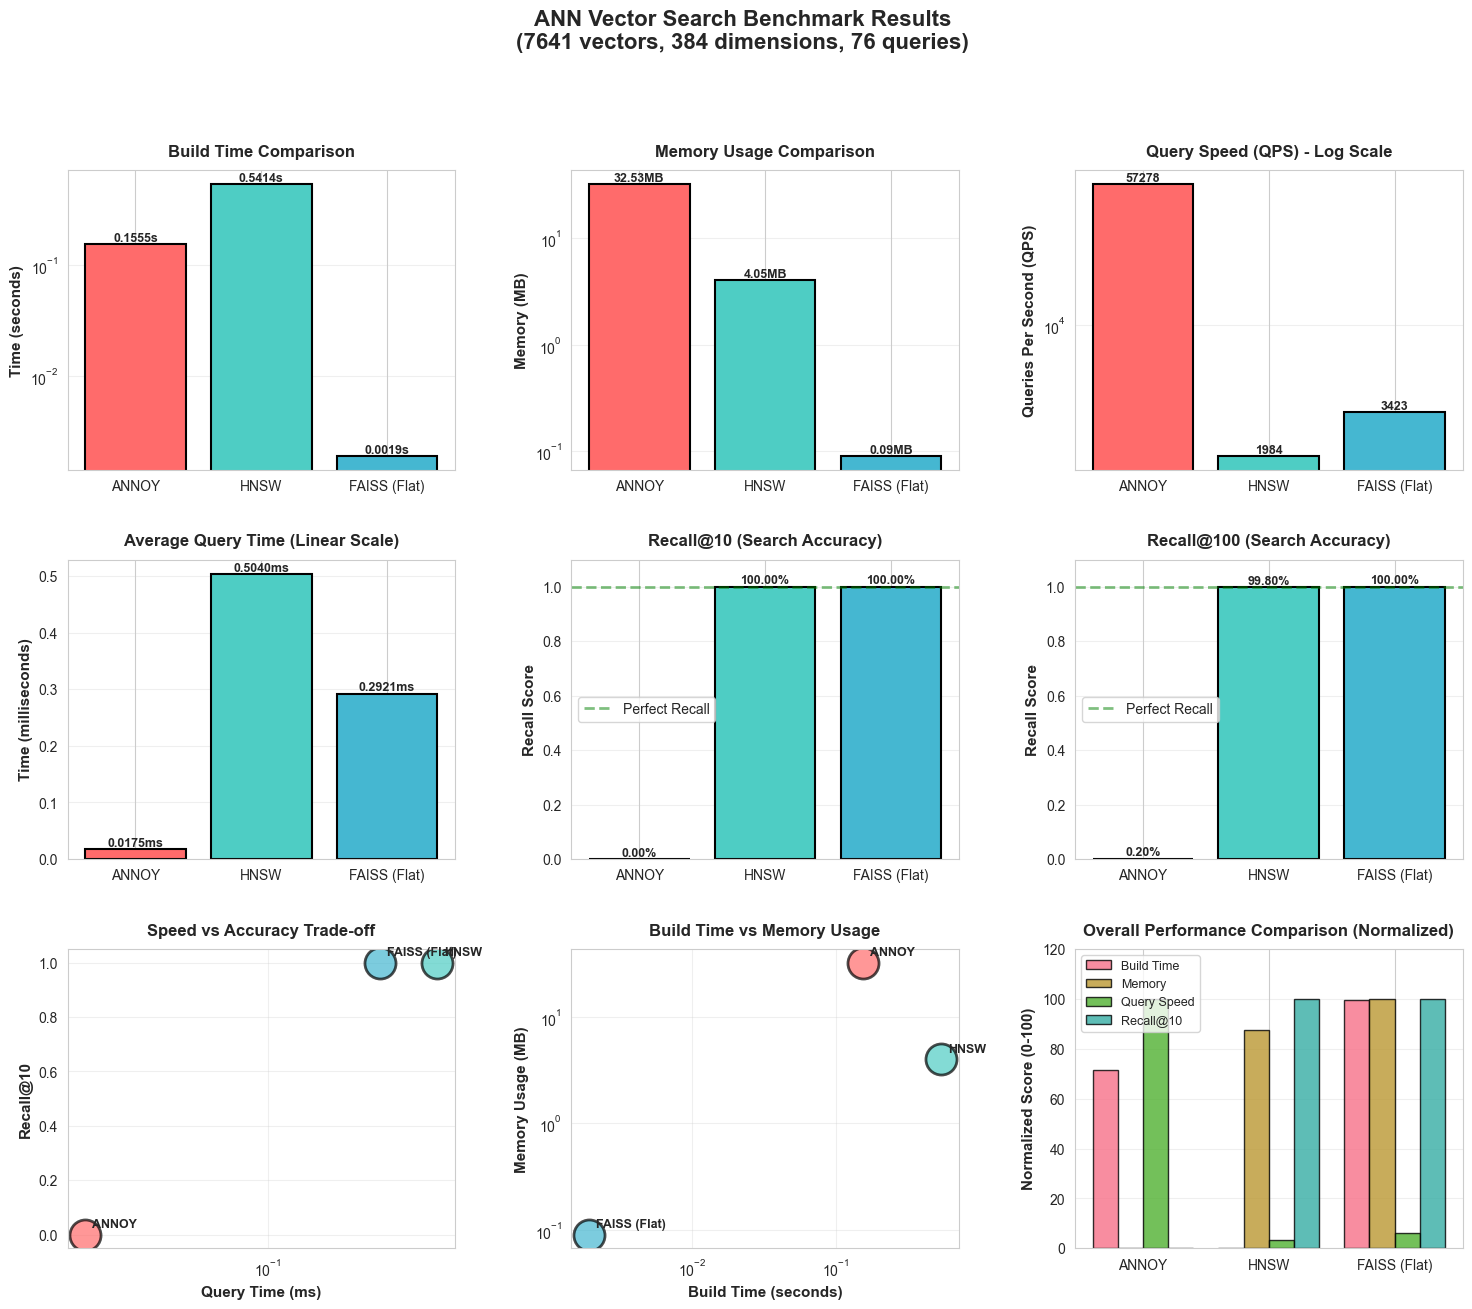

In [10]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors = {'ANNOY': '#FF6B6B', 'HNSW': '#4ECDC4', 'FAISS (Flat)': '#45B7D1'}
color_map = [colors[algo] for algo in df['Algorithm']]

# 1. Build Time (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(df['Algorithm'], df['Build Time (s)'], color=color_map, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax1.set_title('Build Time Comparison', fontsize=12, fontweight='bold', pad=10)
ax1.set_yscale('log')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. Memory Usage (Bar Chart)
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(df['Algorithm'], df['Memory (MB)'], color=color_map, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Memory (MB)', fontsize=11, fontweight='bold')
ax2.set_title('Memory Usage Comparison', fontsize=12, fontweight='bold', pad=10)
ax2.set_yscale('log')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}MB', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Query Speed (QPS) - Log scale
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(df['Algorithm'], df['QPS'], color=color_map, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Queries Per Second (QPS)', fontsize=11, fontweight='bold')
ax3.set_title('Query Speed (QPS) - Log Scale', fontsize=12, fontweight='bold', pad=10)
ax3.set_yscale('log')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4. Query Time (ms) - Linear scale
ax4 = fig.add_subplot(gs[1, 0])
bars4 = ax4.bar(df['Algorithm'], df['Query Time (ms)'], color=color_map, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Time (milliseconds)', fontsize=11, fontweight='bold')
ax4.set_title('Average Query Time (Linear Scale)', fontsize=12, fontweight='bold', pad=10)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# 5. Recall@10
ax5 = fig.add_subplot(gs[1, 1])
bars5 = ax5.bar(df['Algorithm'], df['Recall@10'], color=color_map, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Recall Score', fontsize=11, fontweight='bold')
ax5.set_title('Recall@10 (Search Accuracy)', fontsize=12, fontweight='bold', pad=10)
ax5.set_ylim(0, 1.1)
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax5.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Recall')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Recall@100
ax6 = fig.add_subplot(gs[1, 2])
bars6 = ax6.bar(df['Algorithm'], df['Recall@100'], color=color_map, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Recall Score', fontsize=11, fontweight='bold')
ax6.set_title('Recall@100 (Search Accuracy)', fontsize=12, fontweight='bold', pad=10)
ax6.set_ylim(0, 1.1)
for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax6.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Recall')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Speed vs Accuracy Trade-off (Scatter plot)
ax7 = fig.add_subplot(gs[2, 0])
for idx, row in df.iterrows():
    ax7.scatter(row['Query Time (ms)'], row['Recall@10'], 
               s=500, alpha=0.7, color=colors[row['Algorithm']], 
               edgecolors='black', linewidth=2, label=row['Algorithm'])
    ax7.annotate(row['Algorithm'], 
                xy=(row['Query Time (ms)'], row['Recall@10']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold', fontsize=9)
ax7.set_xlabel('Query Time (ms)', fontsize=11, fontweight='bold')
ax7.set_ylabel('Recall@10', fontsize=11, fontweight='bold')
ax7.set_title('Speed vs Accuracy Trade-off', fontsize=12, fontweight='bold', pad=10)
ax7.grid(True, alpha=0.3)
ax7.set_xscale('log')

# 8. Memory vs Build Time (Scatter plot)
ax8 = fig.add_subplot(gs[2, 1])
for idx, row in df.iterrows():
    ax8.scatter(row['Build Time (s)'], row['Memory (MB)'], 
               s=500, alpha=0.7, color=colors[row['Algorithm']], 
               edgecolors='black', linewidth=2, label=row['Algorithm'])
    ax8.annotate(row['Algorithm'], 
                xy=(row['Build Time (s)'], row['Memory (MB)']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold', fontsize=9)
ax8.set_xlabel('Build Time (seconds)', fontsize=11, fontweight='bold')
ax8.set_ylabel('Memory Usage (MB)', fontsize=11, fontweight='bold')
ax8.set_title('Build Time vs Memory Usage', fontsize=12, fontweight='bold', pad=10)
ax8.grid(True, alpha=0.3)
ax8.set_xscale('log')
ax8.set_yscale('log')

# 9. Normalized Radar-like comparison (using bar chart)
ax9 = fig.add_subplot(gs[2, 2])
# Normalize metrics (0-100 scale, where higher is better for speed/accuracy, lower is better for memory/time)
metrics_normalized = pd.DataFrame()
metrics_normalized['Algorithm'] = df['Algorithm']
metrics_normalized['Build Time'] = 100 - (df['Build Time (s)'] / df['Build Time (s)'].max() * 100)
metrics_normalized['Memory'] = 100 - (df['Memory (MB)'] / df['Memory (MB)'].max() * 100)
metrics_normalized['Query Speed'] = (df['QPS'] / df['QPS'].max() * 100)
metrics_normalized['Recall@10'] = df['Recall@10'] * 100

x = np.arange(len(metrics_normalized))
width = 0.2

metrics_to_plot = ['Build Time', 'Memory', 'Query Speed', 'Recall@10']
for i, metric in enumerate(metrics_to_plot):
    ax9.bar(x + i*width, metrics_normalized[metric], width, 
           label=metric, alpha=0.8, edgecolor='black', linewidth=1)

ax9.set_ylabel('Normalized Score (0-100)', fontsize=11, fontweight='bold')
ax9.set_title('Overall Performance Comparison (Normalized)', fontsize=12, fontweight='bold', pad=10)
ax9.set_xticks(x + width * 1.5)
ax9.set_xticklabels(df['Algorithm'])
ax9.legend(fontsize=9, loc='upper left')
ax9.set_ylim(0, 120)
ax9.grid(axis='y', alpha=0.3)

# Overall title
fig.suptitle('ANN Vector Search Benchmark Results\n(7641 vectors, 384 dimensions, 76 queries)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()